# Troop Booth Signups Analysis

This notebook loads data from (which contains columns such as **Troop**, **Slot Start Time**, **Slot End Time**)  and performs statistical analysis focused on the number of booth signup events per troop. In addition, the notebook identifies and labels potential outliers in the distribution of booth signup counts.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the data file
data_file = "data/2025_booth_signups_unit.csv"

# Set up plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the CSV file (with header)
df = pd.read_csv(data_file)

# Convert time columns to datetime objects
df['Slot Start Time'] = pd.to_datetime(df['Slot Start Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')
df['Slot End Time']   = pd.to_datetime(df['Slot End Time'], format='%Y/%m/%d %H:%M:%S', errors='coerce')

# Display the first few rows
print("Data preview:")
df.head()


Data preview:


,Troop,Troop Email,Slot Start Time,Slot End Time,When Selected Date,When Selected Time,User Selecting
0,3822,naldaz08@yahoo.com,2000-01-01 14:00:00,2000-01-01 16:00:00,2025/01/16 20:14:31,2025/01/16 20:14:31,naldaz08@yahoo.com
1,3822,naldaz08@yahoo.com,2000-01-01 16:00:00,2000-01-01 18:00:00,2025/01/16 20:14:31,2025/01/16 20:14:31,naldaz08@yahoo.com
2,3065,j.savage13@hotmail.com,2000-01-01 10:00:00,2000-01-01 12:00:00,2025/01/14 20:02:38,2025/01/14 20:02:38,kaitlyn.redfield@gmail.com
3,3065,j.savage13@hotmail.com,2000-01-01 14:00:00,2000-01-01 16:00:00,2025/01/14 20:03:02,2025/01/14 20:03:02,kaitlyn.redfield@gmail.com
4,3799,azchesko@gmail.com,2000-01-01 10:00:00,2000-01-01 12:00:00,2025/01/14 20:02:12,2025/01/14 20:02:12,azchesko@gmail.com


In [35]:

# Group by Troop and count the number of signup events per troop
troop_counts = df.groupby('Troop').size().reset_index(name='Num_Booths')

# Sort by number of booths (signup events)
troop_counts.sort_values('Num_Booths', ascending=False, inplace=True)
print("Booth signup counts per troop:")
print(troop_counts)


Booth signup counts per troop:
    Troop  Num_Booths
20   3829          85
0     872          68
16   3822          59
21   3839          31
12   3475          29
6    2820          22
7    2877          20
15   3819          19
11   3315          19
8    3065          18
22   3997          16
17   3824          16
9    3296          16
13   3630          13
1    2554          11
23   4208          11
19   3828          10
24   7223           9
14   3799           8
5    2674           8
10   3312           6
4    2626           5
25   9670           4
18   3827           3
3    2603           3
2    2570           1


In [36]:

# Compute descriptive statistics
desc_stats = troop_counts['Num_Booths'].describe()
print("\nDescriptive statistics for booth signups per troop:")
print(desc_stats)

Q1 = troop_counts['Num_Booths'].quantile(0.25)
Q3 = troop_counts['Num_Booths'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

# Identify outlier troops
outliers = troop_counts[(troop_counts['Num_Booths'] < lower_bound) | (troop_counts['Num_Booths'] > upper_bound)]
print("\nOutlier troops (by number of booth signups):")
print(outliers)


Descriptive statistics for booth signups per troop:
count    26.000000
mean     19.615385
std      20.632163
min       1.000000
25%       8.000000
50%      14.500000
75%      19.750000
max      85.000000
Name: Num_Booths, dtype: float64
Q1: 8.0, Q3: 19.75, IQR: 11.75
Lower bound: -9.625, Upper bound: 37.375

Outlier troops (by number of booth signups):
    Troop  Num_Booths
20   3829          85
0     872          68
16   3822          59


## 5. Visualization with Outlier Labels

Below is a boxplot of the booth signup counts per troop. In addition, we overlay a stripplot (with jitter) for each troop and label the outlier points with the corresponding troop number. We also rescale the x-axis so that the non-outlier data is not bunched up.

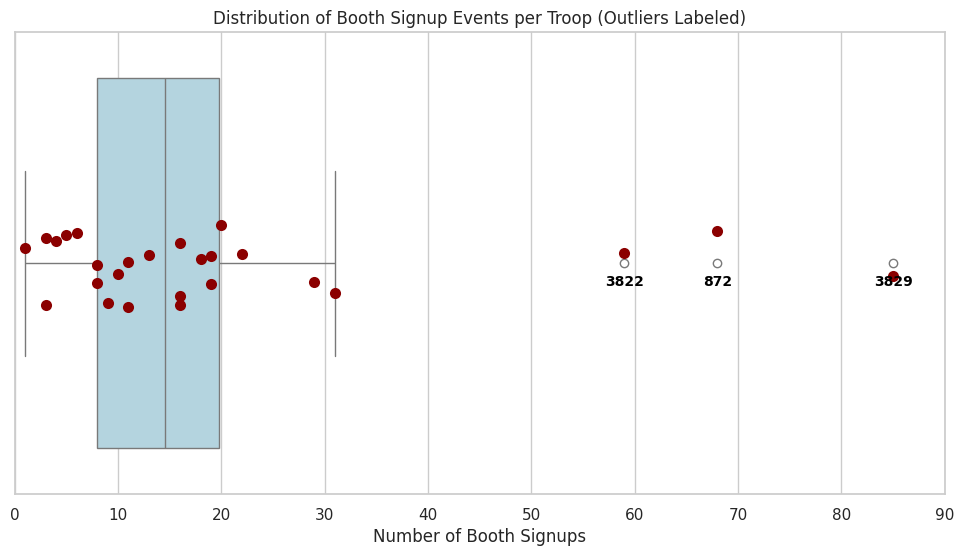

In [37]:
plt.figure(figsize=(12,6))

# Create a horizontal boxplot (vertical orientation) with the signup counts.
ax = sns.boxplot(x='Num_Booths', data=troop_counts, color='lightblue')
sns.stripplot(x='Num_Booths', data=troop_counts, color='darkred', size=8, jitter=True, ax=ax)

# Extend the x-axis: set the limit from 0 to (the maximum number of signups among troops + a margin).
max_val = troop_counts['Num_Booths'].max()
plt.xlim(0, max_val + 5)

# Annotate outlier points with their Troop number
for index, row in troop_counts.iterrows():
    if row['Num_Booths'] < lower_bound or row['Num_Booths'] > upper_bound:
        ax.text(row['Num_Booths'], 0.05, str(row['Troop']),
                horizontalalignment='center', color='black', weight='bold', fontsize=10)

plt.title('Distribution of Booth Signup Events per Troop (Outliers Labeled)')
plt.xlabel('Number of Booth Signups')
plt.show()


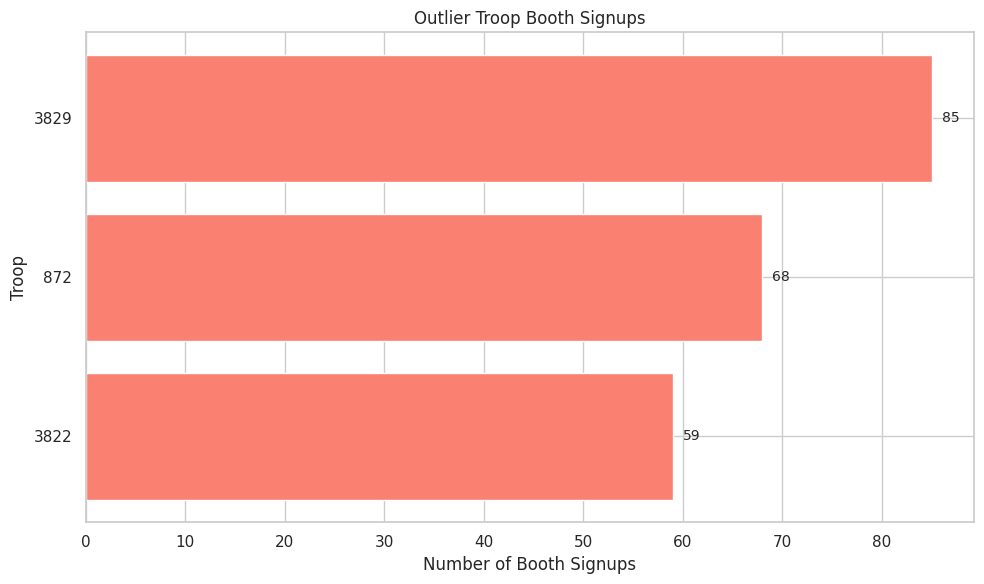

In [38]:
# Additional Visualization: Bar Chart for Outlier Troops Only

# Filter the aggregated data to include only outlier troops
outlier_troops = troop_counts[(troop_counts['Num_Booths'] < lower_bound) | (troop_counts['Num_Booths'] > upper_bound)]

# If there are outliers, create a horizontal bar chart; otherwise, print a message.
if outlier_troops.empty:
    print("No outlier troops detected based on the current IQR thresholds.")
else:
    # Sort the outlier data by number of booth signups in ascending order
    outlier_troops_sorted = outlier_troops.sort_values('Num_Booths', ascending=True)
    
    plt.figure(figsize=(10, 6))
    # Convert the Troop column to string for better labeling on the y-axis.
    plt.barh(outlier_troops_sorted['Troop'].astype(str), outlier_troops_sorted['Num_Booths'], color='salmon')
    plt.xlabel("Number of Booth Signups")
    plt.ylabel("Troop")
    plt.title("Outlier Troop Booth Signups")
    
    # Annotate each bar with its signup count, with a small horizontal offset
    for i, (troop, count) in enumerate(zip(outlier_troops_sorted['Troop'], outlier_troops_sorted['Num_Booths'])):
        plt.text(count + 1, i, str(count), va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


## 6. Save the Summary Data

Finally, we save the aggregated summary (the number of booth signup events per troop) to a CSV file for further reporting or analysis.

In [39]:
output_file = 'troop_booth_summary.csv'
troop_counts.to_csv(output_file, index=False)
print(f"Summary data saved to {output_file}")

Summary data saved to troop_booth_summary.csv
